# 01-pinkify.ipynb

## Import packages

In [3]:
from pathlib import Path
import sys
# Third-party imports
import imageio as iio
import matplotlib.pyplot as plt
import napari
import numpy as np
from skimage import color, exposure, transform, util
# Custom module imports
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)
from src import helpers

In [4]:
%load_ext autoreload
%autoreload 2

## Setup NB and load pink image

In [5]:
viewer = napari.Viewer()

In [6]:
project_dir = Path('..')
project_dir.resolve()

WindowsPath('C:/Users/cgusb/projects/archipelago')

In [7]:
pink_path = Path(project_dir / 'inspiration/seashell-pink.png')
pink_path.exists()

True

In [28]:
pink_img = iio.imread(pink_path)
print(f'{pink_img.shape=}')
print(f'{pink_img.dtype=}')
print(f'{pink_img[:, :, 0].mean()=}')
print(f'{pink_img[:, :, 1].mean()=}')
print(f'{pink_img[:, :, 2].mean()=}')

pink_img.shape=(768, 1024, 3)
pink_img.dtype=dtype('uint8')
pink_img[:, :, 0].mean()=252.0
pink_img[:, :, 1].mean()=231.0
pink_img[:, :, 2].mean()=234.0


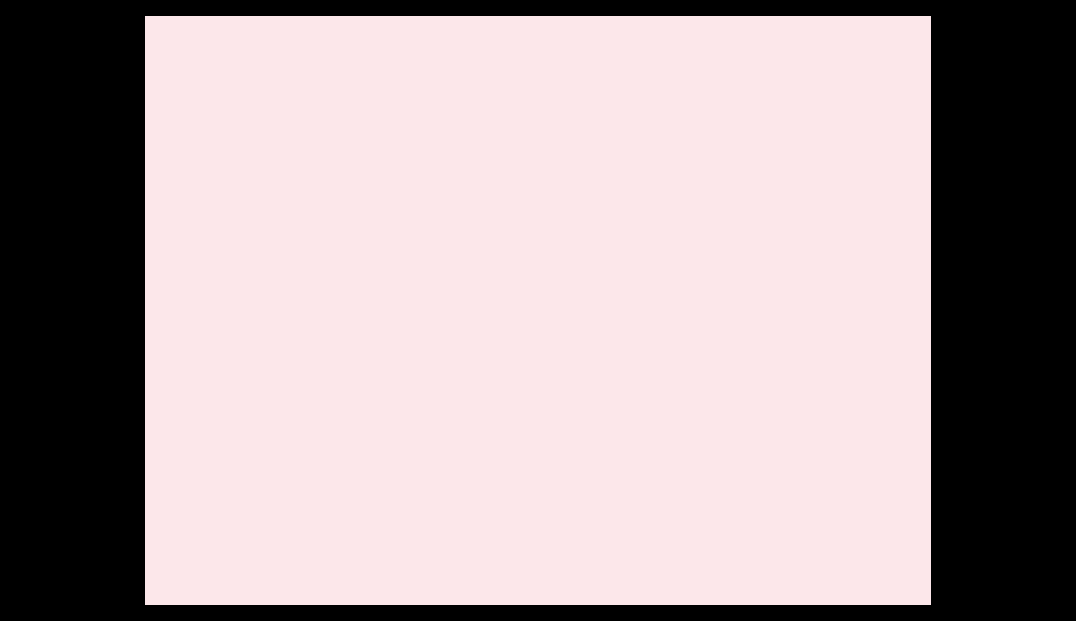

In [9]:
viewer.add_image(pink_img)
napari.utils.nbscreenshot(viewer, canvas_only=True)

In [10]:
pink_hsv = color.rgb2hsv(pink_img)
print(f'{pink_hsv.shape=}')
print(f'{pink_hsv.dtype=}')

pink_hsv.shape=(768, 1024, 3)
pink_hsv.dtype=dtype('float64')


pink_h_mean=0.976190476190477
pink_s_mean=0.08333333333333325
pink_v_mean=0.9882352941176448
pink_h_rgb.dtype=dtype('uint8')


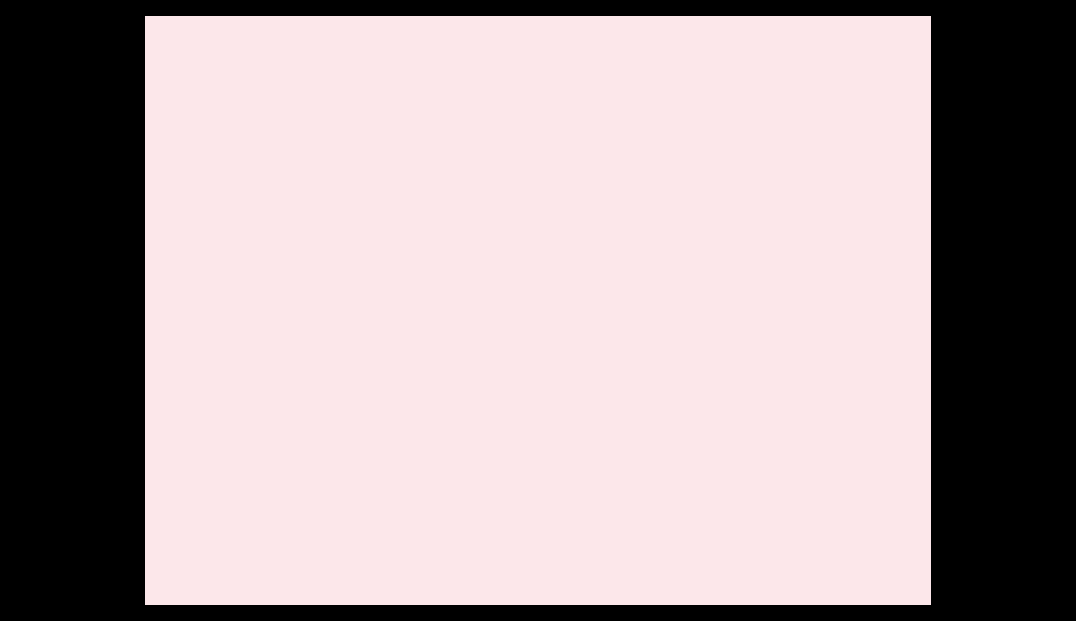

In [11]:
pink_h_hsv = np.zeros_like(pink_hsv)
pink_h_mean = pink_hsv[:, :, 0].mean()
pink_s_mean = pink_hsv[:, :, 1].mean()
pink_v_mean = pink_hsv[:, :, 2].mean()
print(f'{pink_h_mean=}')
print(f'{pink_s_mean=}')
print(f'{pink_v_mean=}')
pink_h_hsv[:, :, 0] = pink_h_mean
pink_h_hsv[:, :, 1] = pink_s_mean
pink_h_hsv[:, :, 2] = pink_v_mean

pink_h_rgb = color.hsv2rgb(pink_h_hsv)
pink_h_rgb = util.img_as_ubyte(pink_h_rgb)
print(f'{pink_h_rgb.dtype=}')

viewer.add_image(pink_h_rgb)
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Load first frame of video

vid_frame.shape=(1920, 1080, 3)
vid_frame.dtype=dtype('uint8')


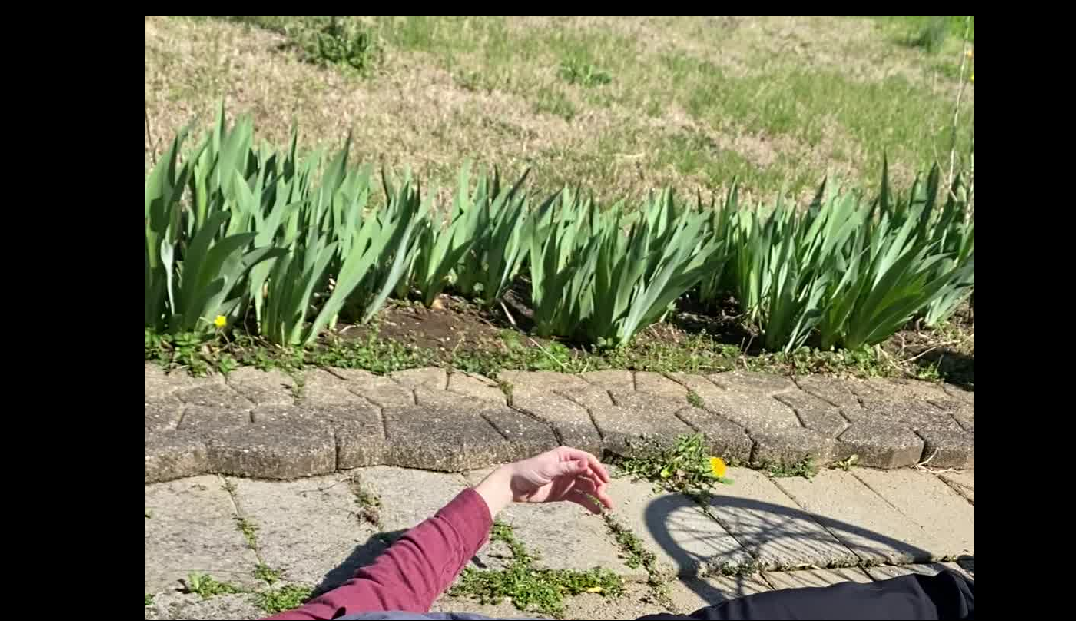

In [13]:
vid_frame_path = Path(project_dir / 'videos/mc-laying/frames/mc-laying-001.jpg')
vid_frame = iio.imread(vid_frame_path)
print(f'{vid_frame.shape=}')
print(f'{vid_frame.dtype=}')
viewer.add_image(vid_frame)
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Rescale image

pink_img.shape=(768, 1024, 3)
vid_frame.shape=(1920, 1080, 3)
vid_frame_resized.shape=(768, 432, 3)


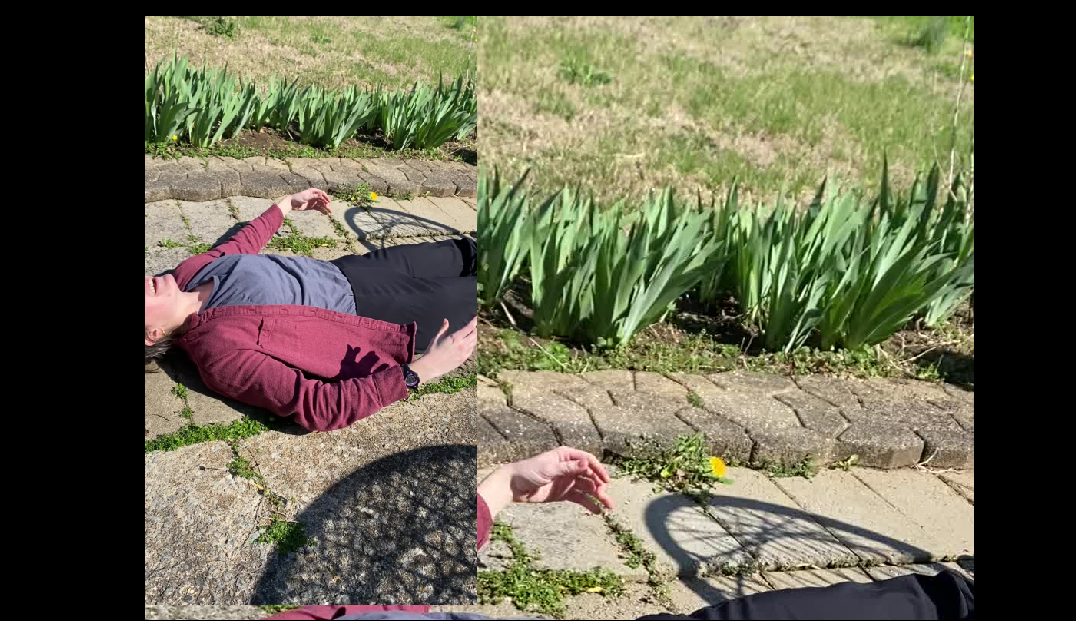

In [14]:
print(f'{pink_img.shape=}')
print(f'{vid_frame.shape=}')
vid_frame_resized = transform.resize(
    vid_frame, 
    (pink_img.shape[0], vid_frame.shape[1] * pink_img.shape[0] / vid_frame.shape[0]), 
    anti_aliasing=True
)
print(f'{vid_frame_resized.shape=}')
viewer.add_image(vid_frame_resized)
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Extract frame hue

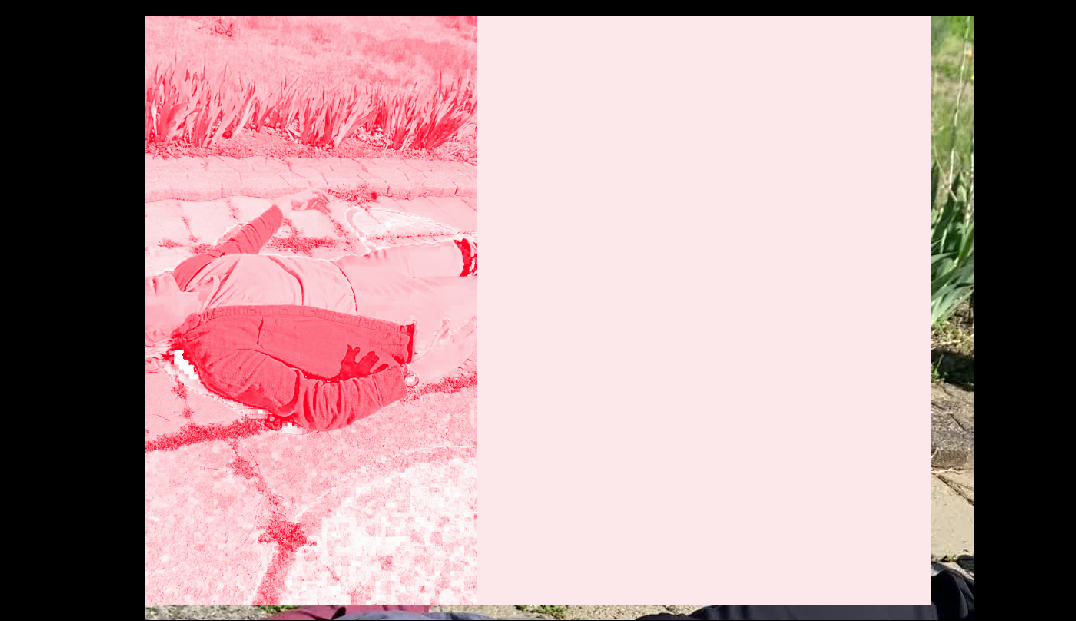

In [15]:
vid_frame_resized_hsv = color.rgb2hsv(vid_frame_resized)
pinkified_hsv = pink_hsv.copy()
pinkified_hsv[:, :vid_frame_resized_hsv.shape[1], 1] = vid_frame_resized_hsv[:, :, 1]
pinkified_rgb = color.hsv2rgb(pinkified_hsv)
viewer.add_image(pinkified_rgb)
napari.utils.nbscreenshot(viewer, canvas_only=True)

In [16]:
def plot_hist(img, chan=None, xlims=(0, 1), cumul=False, vlines=None):

    fig, ax = plt.subplots()
    if len(img.shape) == 2:
        ax.hist(img.ravel())
    elif chan is not None:
        ax.hist(img[:, :, chan].ravel(), bins=256, cumulative=cumul)
    else:
        for chan in range(3):
            ax.hist(img[:, :, chan].ravel(), bins=256)
    ax.set_xlim(xlims[0], xlims[1])

    if vlines is not None:
        try:
            iter(vlines)
        except TypeError:
            vlines = [vlines]
        for v in vlines:
            ax.axvline(v, color='r')


    return fig, ax

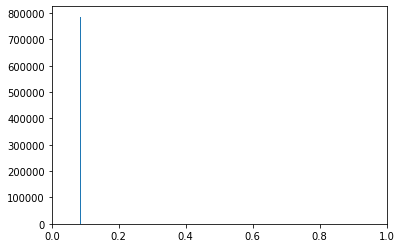

In [17]:
fig, ax = plot_hist(pink_hsv, chan=1)
plt.show()

pink_s_mean=0.08333333333333325


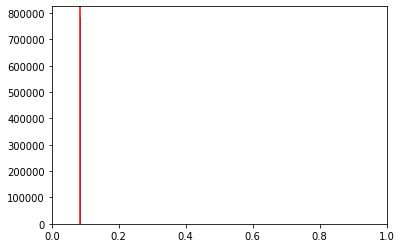

In [18]:
pink_s_mean = pink_hsv[:, :, 1].mean()
print(f'{pink_s_mean=}')
fig, ax = plot_hist(pink_hsv, chan=1, vlines=pink_s_mean)
plt.show()

## Rescale saturation intensity closer to the mean

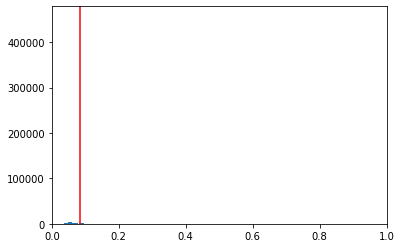

In [19]:
pinkified_s_rescaled_hsv = pinkified_hsv.copy()
pinkified_s_rescaled_hsv[:, :, 1] = exposure.rescale_intensity(
    pinkified_hsv[:, :, 1], out_range=(pink_s_mean - 0.05, pink_s_mean + 0.05)
)
fig, ax = plot_hist(pinkified_s_rescaled_hsv, chan=1, vlines=pink_s_mean)
plt.show()

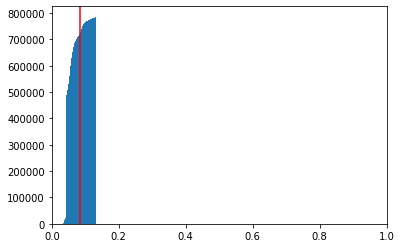

In [20]:
pinkified_s_rescaled_hsv = pinkified_hsv.copy()
pinkified_s_rescaled_hsv[:, :, 1] = exposure.rescale_intensity(
    pinkified_hsv[:, :, 1], out_range=(pink_s_mean - 0.05, pink_s_mean + 0.05)
)
fig, ax = plot_hist(pinkified_s_rescaled_hsv, chan=1, cumul=True, vlines=pink_s_mean)
plt.show()

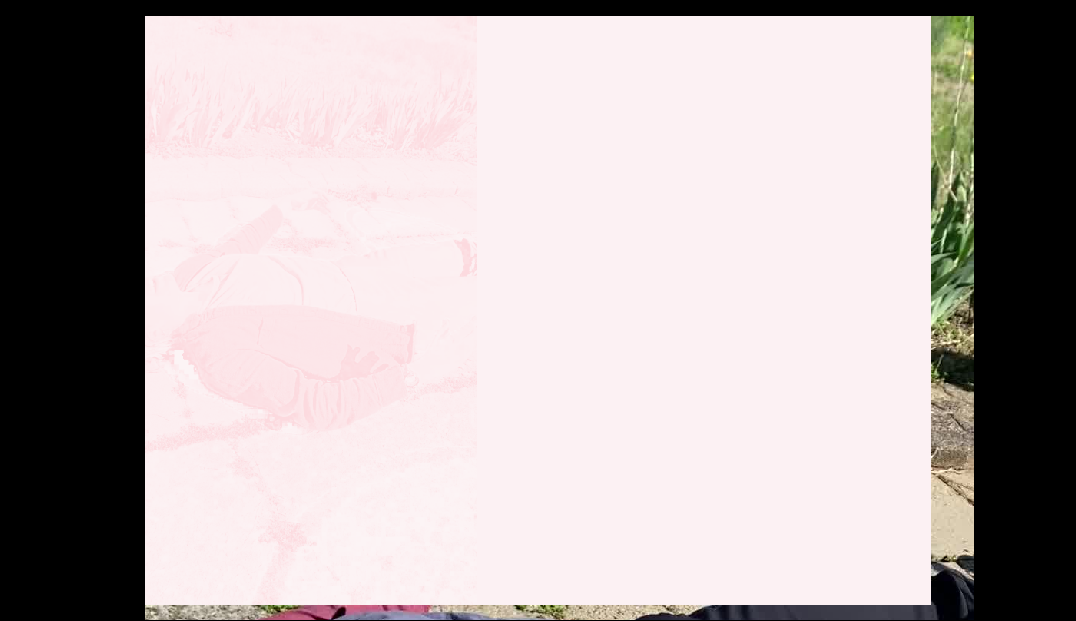

In [21]:
pinkified_s_rescaled_rgb = color.hsv2rgb(pinkified_s_rescaled_hsv)
viewer.add_image(pinkified_s_rescaled_rgb)
napari.utils.nbscreenshot(viewer, canvas_only=True)

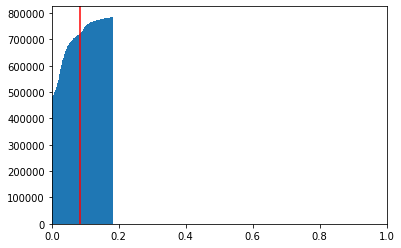

In [22]:
pinkified_s_rescaled_hsv = pinkified_hsv.copy()
pinkified_s_rescaled_hsv[:, :, 1] = exposure.rescale_intensity(
    pinkified_hsv[:, :, 1], out_range=(pink_s_mean - 0.1, pink_s_mean + 0.1)
)
fig, ax = plot_hist(pinkified_s_rescaled_hsv, chan=1, cumul=True, vlines=pink_s_mean)
plt.show()

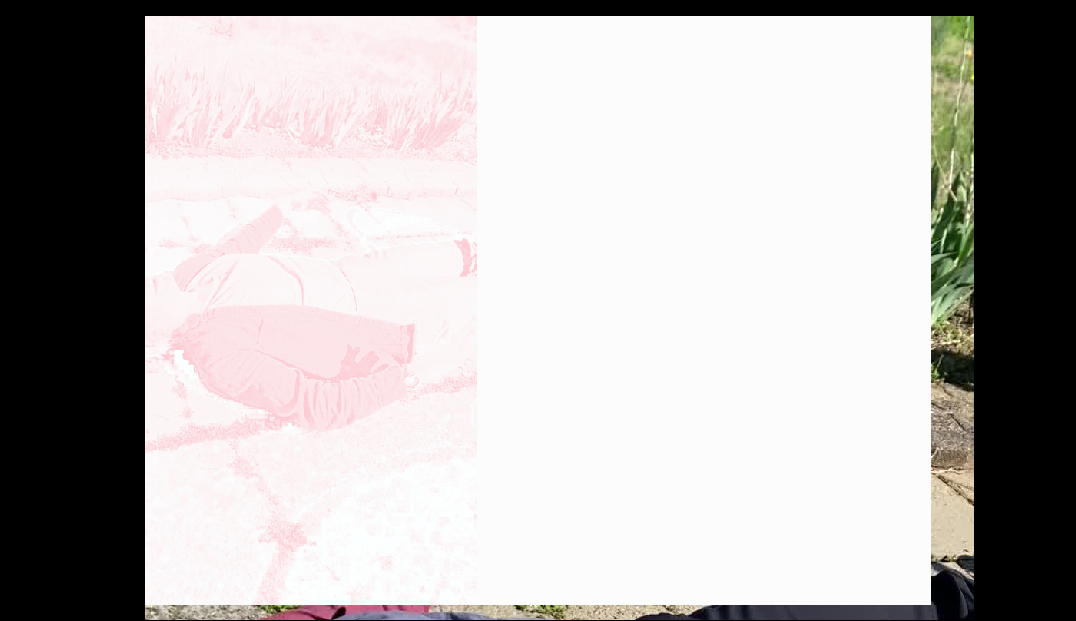

In [23]:
pinkified_s_rescaled_rgb = color.hsv2rgb(pinkified_s_rescaled_hsv)
viewer.add_image(pinkified_s_rescaled_rgb)
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Pinkify all images in directory

In [27]:
img_dir = Path(project_dir / 'videos/mc-laying/frames')
img_paths = [path for path in img_dir.glob('*.jpg')]

# for img_path in img_paths:
img_path = img_paths[0]
img = iio.imread(img_path)
img_hsv = color.rgb2hsv(img)
img_resized = helpers.resize_by_nrows(img, 1080)
canvas = np.zeros((1080, 1920, 3), dtype=np.ubyte)    
# Assign RGB values corresponding to pink image
canvas[:, :, 0] = 252
canvas[:, :, 1] = 231
canvas[:, :, 2] = 234
canvas_hsv = color.rgb2hsv(canvas)


(1080, 1440, 3)


ValueError: could not broadcast input array from shape (1080,1440,3) into shape (1080,1024,3)